In [ ]:
# These codes are developed by Panchajanya Dey, Indian Institute of Science, Bangalore
# as a part of the SRFP project prominence oscillation in solar corona funded by Indian Academy of Science (2023)
# this folder contains the codes are for downloading the necessary fits files, modifying them by multi-gaussian image processing
# and creating an animation that helps to identify the location of the prominence oscillation
# the next part is to determine the pixel coordinates and creating a 4-pixel wide slit and get the corresponding XT map
# which is also covered in this project
# finally handpicking the prominence oscillation from the XT map and fitting it to a damped harmonic oscillation is done
# the final result is the period, damping time and amplitude determination for a LAL prominence oscillation
# I thank Prof. Vaibhav Pant (ARIES) and his group member Upasna Baweja (ARIES) for helping me throughout the project
# and clearing my doubts
# for comments, suggestions and clarity regarding the code contact at the following email address
# panchajanyad@iisc.ac.in

In [1]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import matplotlib.pyplot as plt
import sunpy.visualization.colormaps
from scipy import ndimage
import os
import time as tm
from scipy.interpolate import CubicSpline

In [2]:
path = r"E:\SRFP\Python and Jupyter\Data Cube"
data_files = sorted(os.listdir(path))
data_files[0]

'AIA20160126_162910_0171.txt'

In [3]:
data_files[700][12:18]

'184910'

In [4]:
time = []
for f in data_files:    
    time.append((int(f[10])-6)*86400+int(f[12:14])*3600+int(f[14:16])*60+int(f[16:18]))

In [5]:
frame = [int((t-time[0])/12) for t in time]
for i in range(len(frame)-1):
    if frame[i]==frame[i+1]:
        print(i)

1259


In [6]:
with open(path+'\\'+data_files[700]) as f:
    A = f.readlines()
A[0].split()[0],A[0].split()[-1]

('0.47013259067338287', '-0.21082928549194385')

In [7]:
B = []
for line in A:
    B.append([])
    numbers = line.split()
    for number in numbers:
        B[-1].append(float(number))

In [8]:
xmin = 2000
xmax = 3700
ymin = 400
ymax = 2000

In [9]:
%matplotlib notebook

slit_x = [2178,2226,2284,2350,2396,2464,2521,2566,2648]
slit_y = [1077,1090,1134,1169,1196,1223,1262,1300,1325]
x_data = np.array(slit_x)
y_data = np.array(slit_y)

# Create the cubic spline interpolation function
cubic_interpolation = CubicSpline(x_data, y_data)


cubic_interpolation = CubicSpline(x_data, y_data)
x_values = np.arange(x_data.min(),x_data.max(),1) #,dtype='int')
y_values = cubic_interpolation(x_values)
# y_values = np.array(y_values,dtype='int')
# here pixel values can be fraction as well
local_slope = []
for i in range(len(x_values)-1):
    local_slope.append((y_values[i+1]-y_values[i])/(x_values[i+1]-x_values[i]))
local_slope.append(local_slope[-1])
#local_normal = [-1/m for m in local_slope]
def x_values_add(n): # finds the pixel which is at n length far from the slit and is perpendicular to the slit
    x_arr = []
    for xx,mm in zip(x_values,local_slope):
        x_arr.append((xx-n*mm/(mm**2+1)**0.5))
    return x_arr
def y_values_add(n):
    y_arr = []
    for yy,mm in zip(y_values,local_slope):
        y_arr.append((yy+n/(mm**2+1)**0.5))
    return y_arr

In [15]:
# to extract 4 pixel width slit data
def slit_data(files):
    with open(path+'\\'+files) as f:
        #print(str(f.name[40:])+' : '+str(tm.time()-start))
        A = f.readlines()
    B0 = []
    for line in A:
        B0.append([])
        numbers = line.split()
        for number in numbers:
            B0[-1].append(float(number))
    # function that retrieves intensity value of a fractional pixel
    def pixel_value(x,y):
        xf = int(np.floor(x))
        yf = int(np.floor(y))
        xc = int(np.ceil(x))
        yc = int(np.ceil(y))
        if (xc==xf) and (yc==yf):
            return B0[yc-ymin][xc-xmin]
        elif (xc==xf):
            return B0[yc-ymin][xc-xmin]*(y-yf)/(yc-yf)+B0[yf-ymin][xc-xmin]*(yc-y)/(yc-yf)
        elif (yc==yf):
            return B0[yc-ymin][xc-xmin]*(x-xf)/(xc-xf)+B0[yc-ymin][xf-xmin]*(xc-x)/(xc-xf)
        else:
            return B0[yc-ymin][xc-xmin]*(y-yf)*(x-xf)/((yc-yf)*(xc-xf))+B0[yf-ymin][xc-xmin]*(yc-y)*(x-xf)/((yc-yf)*(xc-xf))+B0[yc-ymin][xf-xmin]*(y-yf)*(xc-x)/((yc-yf)*(xc-xf))+B0[yf-ymin][xf-xmin]*(yc-y)*(xc-x)/((yc-yf)*(xc-xf))

    B = []
    for i in range(len(x_values)):
        #print(x,y)
        ii = pixel_value(x_values[i],y_values[i])+pixel_value(x_values_add(1)[i],y_values_add(1)[i])+pixel_value(x_values_add(-1)[i],y_values_add(-1)[i])+pixel_value(x_values_add(2)[i],y_values_add(2)[i])
        B.append(ii/4)
    return B

<IPython.core.display.Javascript object>


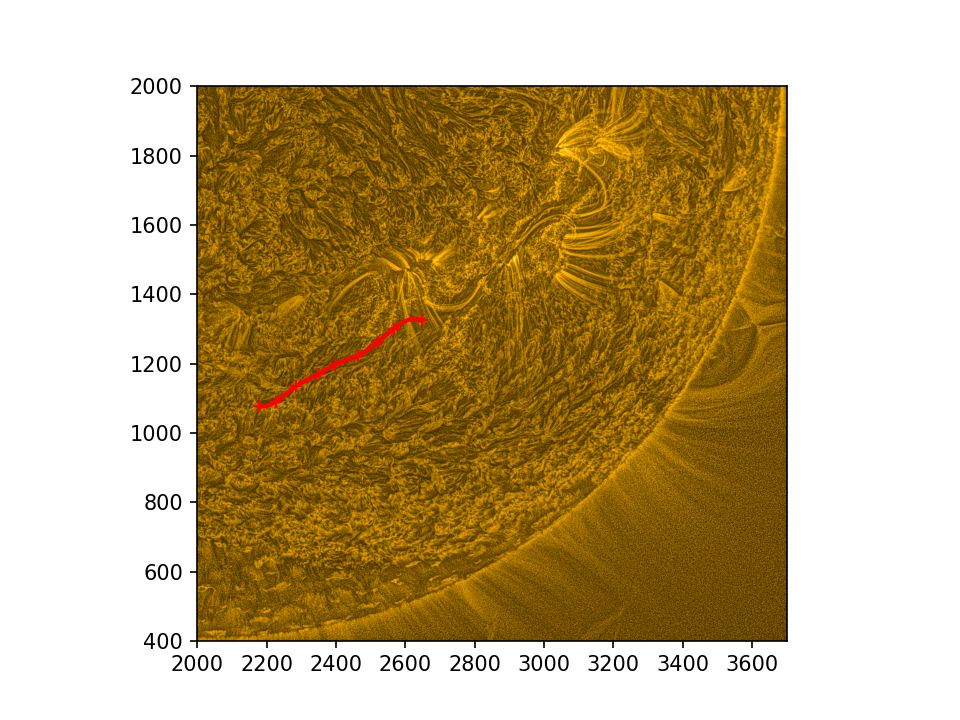

In [11]:
plt.imshow(B,cmap = 'sdoaia171', origin='lower',extent=[xmin, xmax, ymin, ymax])
plt.plot(slit_x,slit_y,'r+')
plt.plot(x_values,y_values,'r')
plt.plot(x_values_add(1),y_values_add(1),'r')
plt.plot(x_values_add(2),y_values_add(2),'r')
plt.plot(x_values_add(-1),y_values_add(-1),'r')

In [12]:
B[slit_y[0]-ymin][slit_x[0]-xmin] # this is how we extract data for slits in this case

0.5024371250524516

In [16]:
Intensity = []
start = tm.time()
for files in data_files:
    print(files+' : '+str(tm.time()-start))
    Intensity.append(slit_data(files))

AIA20160126_162910_0171.txt : 0.0
AIA20160126_162922_0171.txt : 2.3477094173431396
AIA20160126_162934_0171.txt : 4.668517589569092
AIA20160126_162946_0171.txt : 6.987262487411499
AIA20160126_162958_0171.txt : 9.295414209365845
AIA20160126_163010_0171.txt : 11.622304677963257
AIA20160126_163022_0171.txt : 13.936497449874878
AIA20160126_163034_0171.txt : 16.28947687149048
AIA20160126_163046_0171.txt : 18.572142362594604
AIA20160126_163058_0171.txt : 20.896683931350708
AIA20160126_163110_0171.txt : 23.222463846206665
AIA20160126_163122_0171.txt : 25.63132333755493
AIA20160126_163134_0171.txt : 28.006574869155884
AIA20160126_163146_0171.txt : 30.327958345413208
AIA20160126_163158_0171.txt : 32.668551445007324
AIA20160126_163210_0171.txt : 35.027477979660034
AIA20160126_163222_0171.txt : 37.37454104423523
AIA20160126_163234_0171.txt : 39.757556676864624
AIA20160126_163246_0171.txt : 42.11011838912964
AIA20160126_163258_0171.txt : 44.47370195388794
AIA20160126_163310_0171.txt : 47.0800266265

AIA20160126_170310_0171.txt : 407.1205611228943
AIA20160126_170322_0171.txt : 409.4892358779907
AIA20160126_170334_0171.txt : 411.9325225353241
AIA20160126_170346_0171.txt : 414.34641313552856
AIA20160126_170358_0171.txt : 416.74723386764526
AIA20160126_170410_0171.txt : 419.2074999809265
AIA20160126_170422_0171.txt : 421.7085745334625
AIA20160126_170434_0171.txt : 424.0778329372406
AIA20160126_170446_0171.txt : 426.4962077140808
AIA20160126_170458_0171.txt : 428.90642952919006
AIA20160126_170510_0171.txt : 431.3519551753998
AIA20160126_170522_0171.txt : 433.81996393203735
AIA20160126_170534_0171.txt : 436.2395865917206
AIA20160126_170546_0171.txt : 438.60792565345764
AIA20160126_170558_0171.txt : 441.0701947212219
AIA20160126_170610_0171.txt : 443.4571285247803
AIA20160126_170622_0171.txt : 445.8058931827545
AIA20160126_170634_0171.txt : 448.20598006248474
AIA20160126_170646_0171.txt : 450.6349530220032
AIA20160126_170658_0171.txt : 453.2862114906311
AIA20160126_170710_0171.txt : 455.

AIA20160126_173722_0171.txt : 853.0544717311859
AIA20160126_173734_0171.txt : 855.5099050998688
AIA20160126_173746_0171.txt : 857.9622304439545
AIA20160126_173758_0171.txt : 860.3927240371704
AIA20160126_173810_0171.txt : 862.8766536712646
AIA20160126_173822_0171.txt : 865.4622483253479
AIA20160126_173834_0171.txt : 867.8698546886444
AIA20160126_173846_0171.txt : 870.3586211204529
AIA20160126_173858_0171.txt : 872.867137670517
AIA20160126_173910_0171.txt : 875.3975780010223
AIA20160126_173922_0171.txt : 877.785445690155
AIA20160126_173934_0171.txt : 880.2637541294098
AIA20160126_173946_0171.txt : 882.7564535140991
AIA20160126_173958_0171.txt : 885.2922534942627
AIA20160126_174010_0171.txt : 887.8249127864838
AIA20160126_174022_0171.txt : 890.3068299293518
AIA20160126_174034_0171.txt : 892.8866853713989
AIA20160126_174046_0171.txt : 895.4191029071808
AIA20160126_174058_0171.txt : 897.9005014896393
AIA20160126_174110_0171.txt : 900.3723146915436
AIA20160126_174122_0171.txt : 902.78705525

AIA20160126_181122_0171.txt : 1290.215732574463
AIA20160126_181134_0171.txt : 1292.6704397201538
AIA20160126_181146_0171.txt : 1295.136290550232
AIA20160126_181158_0171.txt : 1297.601669549942
AIA20160126_181210_0171.txt : 1300.1076920032501
AIA20160126_181222_0171.txt : 1302.7819159030914
AIA20160126_181234_0171.txt : 1305.401692390442
AIA20160126_181246_0171.txt : 1307.9396214485168
AIA20160126_181258_0171.txt : 1310.4478886127472
AIA20160126_181310_0171.txt : 1313.1812436580658
AIA20160126_181322_0171.txt : 1315.7876961231232
AIA20160126_181334_0171.txt : 1318.3626708984375
AIA20160126_181346_0171.txt : 1321.3530163764954
AIA20160126_181358_0171.txt : 1324.0543746948242
AIA20160126_181410_0171.txt : 1326.6736295223236
AIA20160126_181422_0171.txt : 1329.2222018241882
AIA20160126_181434_0171.txt : 1331.8513746261597
AIA20160126_181446_0171.txt : 1334.5359485149384
AIA20160126_181458_0171.txt : 1337.0070106983185
AIA20160126_181510_0171.txt : 1339.5799219608307
AIA20160126_181522_0171.

AIA20160126_184458_0171.txt : 1734.3773839473724
AIA20160126_184510_0171.txt : 1736.9495375156403
AIA20160126_184522_0171.txt : 1740.7922704219818
AIA20160126_184534_0171.txt : 1743.3038454055786
AIA20160126_184546_0171.txt : 1745.7543025016785
AIA20160126_184558_0171.txt : 1748.243126153946
AIA20160126_184610_0171.txt : 1750.7175352573395
AIA20160126_184622_0171.txt : 1753.1668510437012
AIA20160126_184634_0171.txt : 1755.6452069282532
AIA20160126_184646_0171.txt : 1758.4287765026093
AIA20160126_184658_0171.txt : 1760.983892917633
AIA20160126_184710_0171.txt : 1763.570151567459
AIA20160126_184722_0171.txt : 1766.4017646312714
AIA20160126_184734_0171.txt : 1769.0259034633636
AIA20160126_184746_0171.txt : 1771.492793083191
AIA20160126_184758_0171.txt : 1774.2839906215668
AIA20160126_184810_0171.txt : 1776.924114227295
AIA20160126_184822_0171.txt : 1779.5046825408936
AIA20160126_184834_0171.txt : 1782.0570981502533
AIA20160126_184846_0171.txt : 1784.5980615615845
AIA20160126_184858_0171.t

AIA20160126_191846_0171.txt : 2164.1185450553894
AIA20160126_191858_0171.txt : 2166.5111050605774
AIA20160126_191910_0171.txt : 2168.9717659950256
AIA20160126_191922_0171.txt : 2171.3655455112457
AIA20160126_191934_0171.txt : 2173.838392019272
AIA20160126_191946_0171.txt : 2176.249718427658
AIA20160126_191958_0171.txt : 2178.766419649124
AIA20160126_192010_0171.txt : 2181.6704778671265
AIA20160126_192022_0171.txt : 2184.1117396354675
AIA20160126_192034_0171.txt : 2186.6749591827393
AIA20160126_192046_0171.txt : 2189.2704405784607
AIA20160126_192058_0171.txt : 2191.724592924118
AIA20160126_192110_0171.txt : 2194.2289192676544
AIA20160126_192122_0171.txt : 2196.738331079483
AIA20160126_192134_0171.txt : 2199.3615515232086
AIA20160126_192146_0171.txt : 2201.9398589134216
AIA20160126_192158_0171.txt : 2204.4667999744415
AIA20160126_192210_0171.txt : 2207.2039926052094
AIA20160126_192222_0171.txt : 2209.9073700904846
AIA20160126_192234_0171.txt : 2212.8406250476837
AIA20160126_192246_0171.t

AIA20160126_195234_0171.txt : 2590.643858909607
AIA20160126_195246_0171.txt : 2593.0973386764526
AIA20160126_195258_0171.txt : 2595.50559926033
AIA20160126_195310_0171.txt : 2597.95108962059
AIA20160126_195322_0171.txt : 2600.427900314331
AIA20160126_195334_0171.txt : 2602.871636390686
AIA20160126_195346_0171.txt : 2605.3833944797516
AIA20160126_195358_0171.txt : 2607.9029190540314
AIA20160126_195410_0171.txt : 2610.2233381271362
AIA20160126_195422_0171.txt : 2612.606770992279
AIA20160126_195434_0171.txt : 2615.023715734482
AIA20160126_195446_0171.txt : 2617.497355222702
AIA20160126_195458_0171.txt : 2619.8961420059204
AIA20160126_195510_0171.txt : 2622.293714284897
AIA20160126_195522_0171.txt : 2624.7553737163544
AIA20160126_195534_0171.txt : 2627.217761993408
AIA20160126_195546_0171.txt : 2629.5995347499847
AIA20160126_195558_0171.txt : 2632.0639247894287
AIA20160126_195610_0171.txt : 2634.4424271583557
AIA20160126_195622_0171.txt : 2636.906744480133
AIA20160126_195634_0171.txt : 263

AIA20160126_204446_0171.txt : 3019.9542758464813
AIA20160126_204458_0171.txt : 3022.441823244095
AIA20160126_204510_0171.txt : 3024.9902307987213
AIA20160126_204522_0171.txt : 3027.4450900554657
AIA20160126_204534_0171.txt : 3030.131405353546
AIA20160126_204546_0171.txt : 3033.0746126174927
AIA20160126_204558_0171.txt : 3035.5125312805176
AIA20160126_204610_0171.txt : 3038.0361371040344
AIA20160126_204622_0171.txt : 3040.5218069553375
AIA20160126_204634_0171.txt : 3042.980849981308
AIA20160126_204646_0171.txt : 3045.449626684189
AIA20160126_204658_0171.txt : 3047.8840160369873
AIA20160126_204710_0171.txt : 3050.3537273406982
AIA20160126_204722_0171.txt : 3052.8106088638306
AIA20160126_204734_0171.txt : 3055.3119933605194
AIA20160126_204746_0171.txt : 3057.7429172992706
AIA20160126_204758_0171.txt : 3060.3215420246124
AIA20160126_204810_0171.txt : 3062.7306864261627
AIA20160126_204822_0171.txt : 3065.2166633605957
AIA20160126_204834_0171.txt : 3067.7287154197693
AIA20160126_204846_0171.

IndexError: list index out of range

<IPython.core.display.Javascript object>


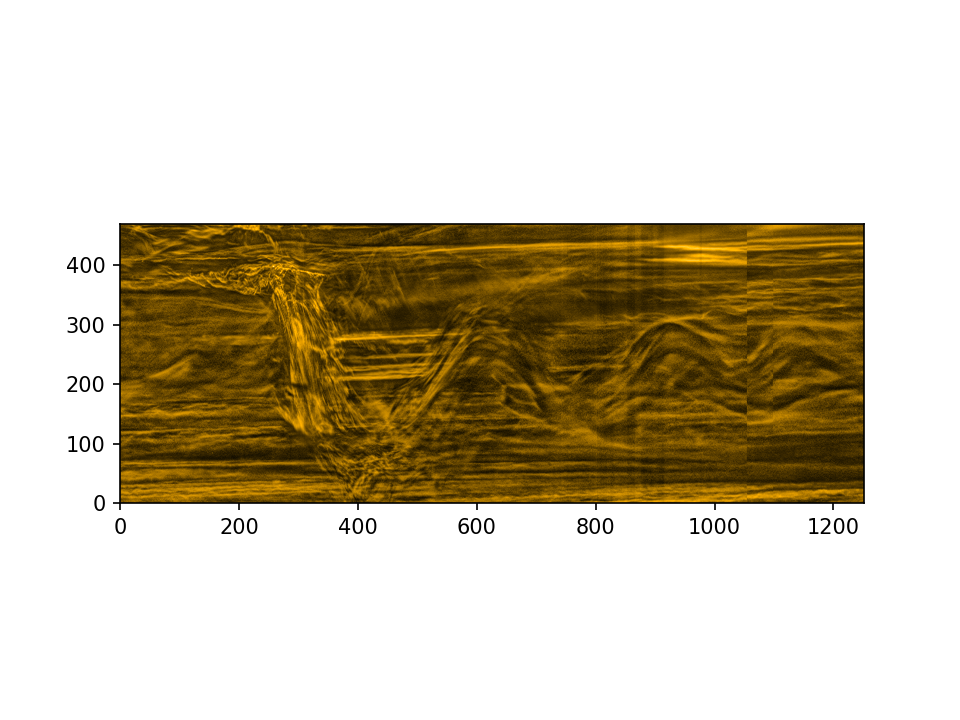

In [18]:
plt.imshow(np.transpose(Intensity),origin = 'lower',cmap = 'sdoaia171')

In [20]:
len(Intensity),len(Intensity[0])

(1252, 470)

In [19]:
n = 0
i = 0
corrected_intensity = []
while(n<=frame[-1]):
    if n in frame:        
        corrected_intensity.append(Intensity[i])
        i += 1
        n+=1
    else:
        '''x = n
        count = 0
        while x not in frame:
            x += 1
            count += 1
        for ii in range(0,count):
            corrected_intensity.append([(x*(count-ii)+y*(ii+1))/(1+count) for x,y in zip(Intensity_data[i],Intensity_data[i+1])])
        n = x'''
        corrected_intensity.append(np.full_like(Intensity[0],float('nan')))
        n+=1
    

IndexError: list index out of range